# Cybersecurity Cases

This notebook implements the full coding pipeline required by the project brief and the PPT:

* Data loading and preprocessing

* Exploratory data analysis (EDA)

* Unsupervised anomaly detection (IsolationForest)

* Supervised classification baseline (RandomForest)

## TensorFlow visualizations:

* Universal Sentence Encoder (TF-Hub) + UMAP/t-SNE embedding visualization

* TensorFlow Keras Autoencoder for anomaly detection and 2D latent visualization

## Outputs: figures in plots/, CSVs & JSON in results/, saved models in results/

# Reproducibility seeds

In [36]:
import numpy as np, random, tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Required libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("Packages installed.")

Packages installed.


## Dataset Cybersecurity Incidents in India (2020–2024)
[Kaggle](https://www.kaggle.com/datasets/saisimha203/cybersecurity-cases-india)

In [2]:
DATA_PATH = "/content/cybersecurity_cases_india_combined.csv"
print("DATA_PATH =", DATA_PATH)

DATA_PATH = /content/cybersecurity_cases_india_combined.csv


## Imports, helper functions and folders

In [4]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# Machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import joblib
# Plot helper
def save_fig(fig, path, dpi=150):
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    print("Saved:", path)
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)
sns.set_style('whitegrid')

## Load Dataset

In [5]:
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head(8))
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:")
display(df.isna().sum())
if 'Amount_Lost_INR' in df.columns:
    df['Amount_Lost_INR'] = pd.to_numeric(df['Amount_Lost_INR'], errors='coerce')
    print("\nAmount_Lost_INR summary:")
    display(df['Amount_Lost_INR'].describe())

Dataset shape: (1200, 6)


,Year,Day,Amount_Lost_INR,Incident_Type,City,Category
0,2022,22,86530,Data Breach,Bangalore,Corporate
1,2023,21,231983,Phishing,Kolkata,Educational
2,2021,6,284707,Data Breach,Bangalore,E-commerce
3,2023,6,433557,Phishing,Ahmedabad,Health
4,2023,23,378816,Phishing,Jaipur,Government
5,2020,16,399992,Phishing,Mumbai,Corporate
6,2021,4,430660,Online Fraud,Kolkata,Financial
7,2021,11,463132,Ransomware,Ahmedabad,Health



Columns: ['Year', 'Day', 'Amount_Lost_INR', 'Incident_Type', 'City', 'Category']

Missing values per column:


,0
Year,0
Day,0
Amount_Lost_INR,0
Incident_Type,0
City,0
Category,0



Amount_Lost_INR summary:


,Amount_Lost_INR
count,1200.000000
mean,231538.652500
std,138431.719958
min,2969.000000
25%,115619.500000
50%,220486.500000
75%,341963.000000
max,499946.000000


## Clean and Standardize Fields; Feature Engineering

In [6]:
for c in ['Incident_Type', 'City', 'Category']:
    if c in df.columns:
        df[c] = (
            df[c]
            .fillna('')
            .astype(str)
            .str.strip()
            .str.title()
        )
if 'Year' in df.columns and 'Day' in df.columns:
    try:
        df['Year'] = df['Year'].astype(int)
        df['Day'] = df['Day'].astype(int)
        df['event_date'] = (
            pd.to_datetime(df['Year'].astype(str) + '-01-01') +
            pd.to_timedelta(df['Day'] - 1, unit='D')
        )
    except Exception as e:
        print("Could not create event_date:", e)
if 'Amount_Lost_INR' in df.columns:
    df['Amount_Lost_INR'] = df['Amount_Lost_INR'].fillna(df['Amount_Lost_INR'].median())
le_incident = LabelEncoder()
df['Incident_label'] = le_incident.fit_transform(df['Incident_Type'].astype(str))

le_city = LabelEncoder()
df['City_enc'] = le_city.fit_transform(df['City'].astype(str))

le_cat = LabelEncoder()
df['Category_enc'] = le_cat.fit_transform(df['Category'].astype(str))
display(
    df[
        [
            'Incident_Type', 'Incident_label',
            'City', 'City_enc',
            'Category', 'Category_enc',
            'Amount_Lost_INR'
        ]
    ].head(8)
)

,Incident_Type,Incident_label,City,City_enc,Category,Category_enc,Amount_Lost_INR
0,Data Breach,1,Bangalore,1,Corporate,0,86530
1,Phishing,8,Kolkata,6,Educational,2,231983
2,Data Breach,1,Bangalore,1,E-Commerce,1,284707
3,Phishing,8,Ahmedabad,0,Health,5,433557
4,Phishing,8,Jaipur,5,Government,4,378816
5,Phishing,8,Mumbai,8,Corporate,0,399992
6,Online Fraud,6,Kolkata,6,Financial,3,430660
7,Ransomware,9,Ahmedabad,0,Health,5,463132


## Exploratory Visualizations: Incident Types, Trends, Cities, Loss Analysis

### Top Incident Types

Saved: plots/top_incident_types.png


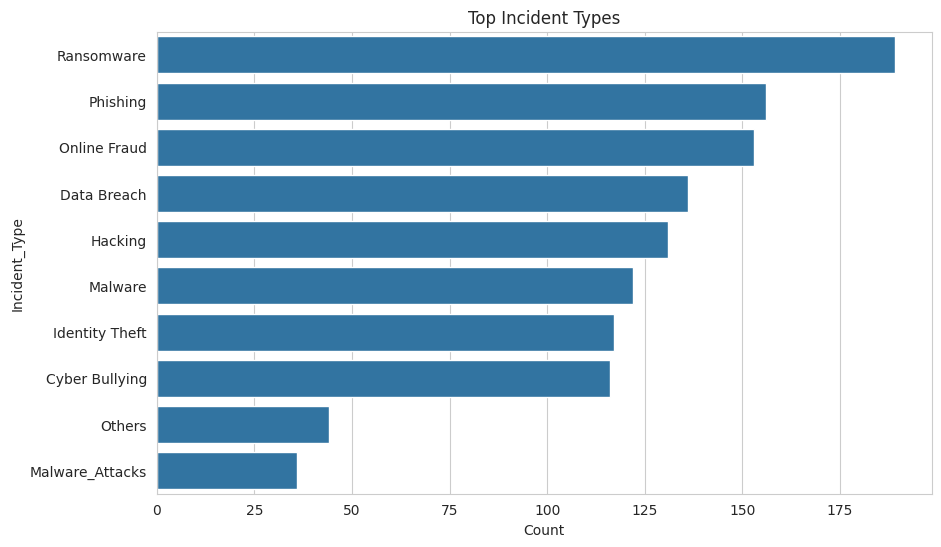

In [7]:
plt.figure(figsize=(10,6))
type_counts = df['Incident_Type'].value_counts().head(12)
sns.barplot(x=type_counts.values, y=type_counts.index)
plt.title("Top Incident Types")
plt.xlabel("Count")
save_fig(plt.gcf(), "plots/top_incident_types.png")
plt.show()

## Trends by Year for Top 6 Incident Types

Saved: plots/incident_trends_top6.png


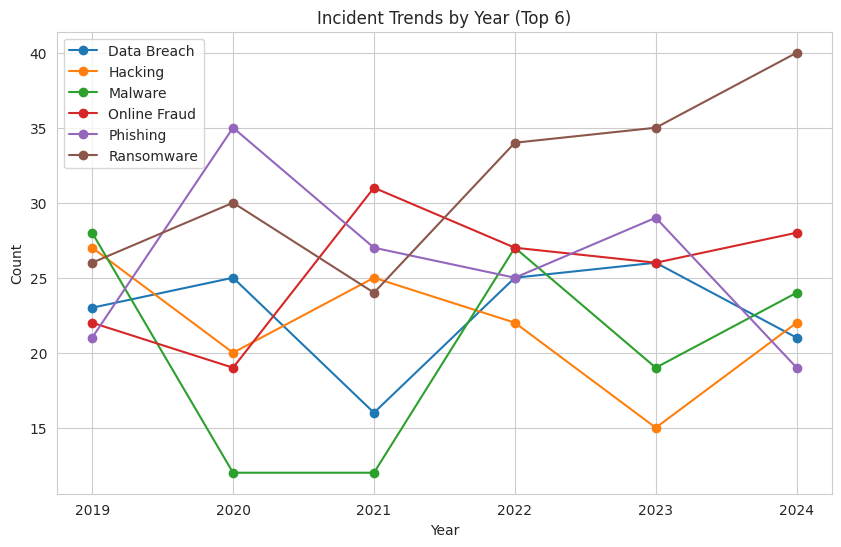

In [8]:
top6 = type_counts.index[:6].tolist()

if 'Year' in df.columns:
    trend = (
        df[df['Incident_Type'].isin(top6)]
        .groupby(['Year', 'Incident_Type'])
        .size()
        .unstack(fill_value=0)
    )

    plt.figure(figsize=(10,6))
    for col in trend.columns:
        plt.plot(trend.index, trend[col], marker='o', label=col)

    plt.legend()
    plt.title("Incident Trends by Year (Top 6)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    save_fig(plt.gcf(), "plots/incident_trends_top6.png")
    plt.show()

## Top Cities

Saved: plots/top_cities.png


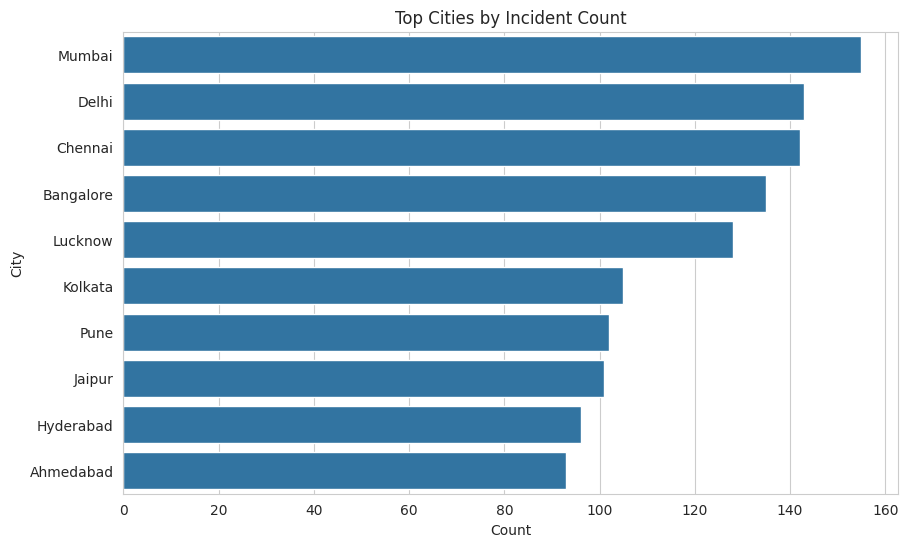

In [9]:
plt.figure(figsize=(10,6))
city_top = df['City'].value_counts().head(12)
sns.barplot(x=city_top.values, y=city_top.index)
plt.title("Top Cities by Incident Count")
plt.xlabel("Count")
save_fig(plt.gcf(), "plots/top_cities.png")
plt.show()

## Loss Summary by Incident Type

,count,sum,mean
Incident_Type,,,
Ransomware,189,41098786,217453.894180
Phishing,156,34713968,222525.435897
Data Breach,136,34102131,250750.963235
Online Fraud,153,33822815,221064.150327
Hacking,131,32620076,249008.213740
Identity Theft,117,31035885,265263.974359
Malware,122,30369058,248926.704918
Cyber Bullying,116,28154376,242710.137931
Others,44,6215929,141271.113636


Saved: plots/loss_by_type_top12.png


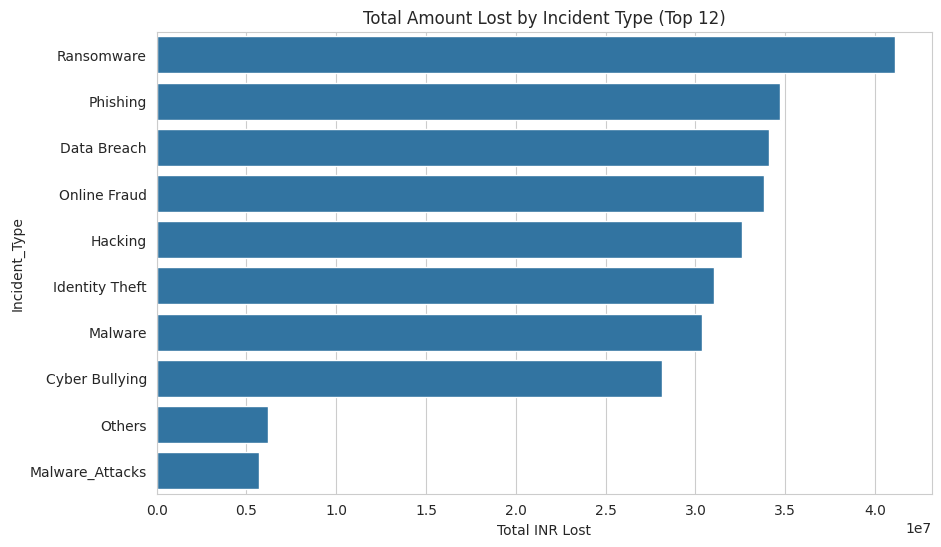

In [10]:
loss = (
    df.groupby('Incident_Type')['Amount_Lost_INR']
    .agg(['count', 'sum', 'mean'])
    .sort_values('sum', ascending=False)
    .head(12)
)

display(loss)

plt.figure(figsize=(10,6))
sns.barplot(x=loss['sum'].values, y=loss.index)
plt.title("Total Amount Lost by Incident Type (Top 12)")
plt.xlabel("Total INR Lost")
save_fig(plt.gcf(), "plots/loss_by_type_top12.png")
plt.show()

## Save Tables

In [11]:
loss.to_csv("results/loss_summary_by_incident_type.csv")
type_counts.to_csv("results/incident_type_counts.csv", header=['count'])

# IsolationForest (unsupervised anomaly detection baseline)

,Incident_Type,City,Amount_Lost_INR,Year,iso_score,iso_anomaly
416,Identity Theft,Pune,473132,2019,-0.035337,1
697,Data Breach,Pune,494948,2019,-0.029561,1
390,Malware,Pune,497758,2019,-0.024677,1
334,Data Breach,Mumbai,475112,2024,-0.017556,1
489,Online Fraud,Ahmedabad,32348,2019,-0.014687,1
962,Data Breach,Pune,484569,2019,-0.014327,1
126,Online Fraud,Pune,34320,2024,-0.013687,1
423,Ransomware,Pune,411303,2024,-0.013107,1
98,Ransomware,Pune,57985,2019,-0.012503,1
825,Ransomware,Ahmedabad,488689,2024,-0.010421,1


Saved: plots/iso_anomalies_scatter.png


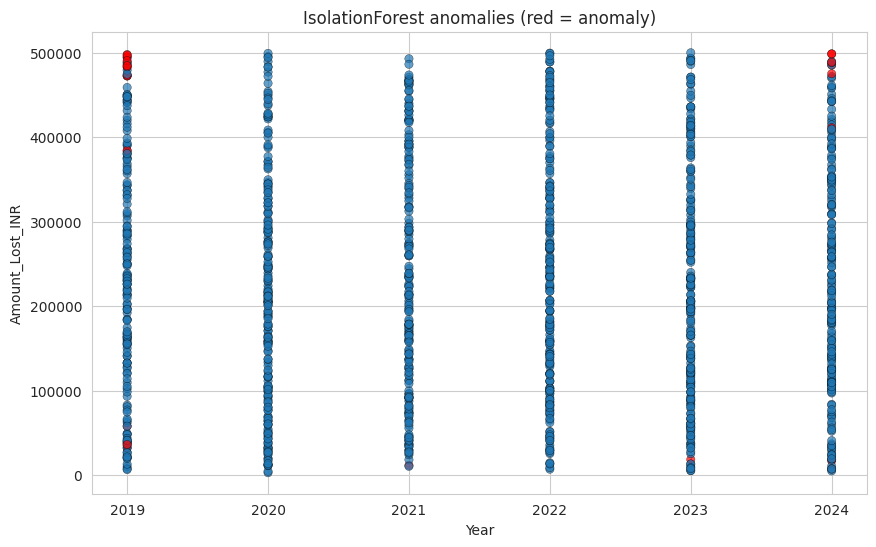

Saved scaler and IsolationForest model to results/


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib
features_iso = []
if 'Amount_Lost_INR' in df.columns:
    features_iso.append('Amount_Lost_INR')
if 'City_enc' in df.columns:
    features_iso.append('City_enc')
if 'Category_enc' in df.columns:
    features_iso.append('Category_enc')
if 'Year' in df.columns:
    features_iso.append('Year')
if len(features_iso) == 0:
    print("No numeric/encoded features available for IsolationForest. Add features and rerun.")
else:
    X_iso = df[features_iso].fillna(0).values
    scaler_iso = StandardScaler()
    X_iso_scaled = scaler_iso.fit_transform(X_iso)
    iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
    iso.fit(X_iso_scaled)
    df.loc[:, 'iso_score'] = iso.decision_function(X_iso_scaled)
    df.loc[:, 'iso_anomaly'] = (iso.predict(X_iso_scaled) == -1).astype(int)
    display(
        df.sort_values('iso_score').head(15)[
            ['Incident_Type', 'City', 'Amount_Lost_INR', 'Year', 'iso_score', 'iso_anomaly']
            .copy()
        ].fillna('')
    )
    # Scatter anomaly visualization (Year vs Amount_Lost_INR if Year exists, else index)
    plt.figure(figsize=(10,6))
    if 'Year' in df.columns:
        x_vals = df['Year']
        xlabel = 'Year'
    else:
        x_vals = df.index
        xlabel = 'Index'
    # Color mapping for anomalies
    colors = df['iso_anomaly'].map({0: 'C0', 1: 'r'}).values

    plt.scatter(x_vals, df['Amount_Lost_INR'], c=colors, alpha=0.7, edgecolor='k', linewidth=0.3)
    plt.title("IsolationForest anomalies (red = anomaly)")
    plt.xlabel(xlabel)
    plt.ylabel("Amount_Lost_INR")
    save_fig(plt.gcf(), "plots/iso_anomalies_scatter.png")
    plt.show()
    try:
        os.makedirs("results", exist_ok=True)
        joblib.dump(scaler_iso, "results/scaler_iso.joblib")
        joblib.dump(iso, "results/isolation_forest.joblib")
        print("Saved scaler and IsolationForest model to results/")
    except Exception as e:
        print("Could not save model/scaler:", e)

#Synthetic anomaly labels
---
## Create synthetic anomaly label based on top 2% Amount_Lost_INR

In [13]:
if 'Amount_Lost_INR' in df.columns:
    # ensure numeric
    df['Amount_Lost_INR'] = pd.to_numeric(df['Amount_Lost_INR'], errors='coerce').fillna(0)
    threshold_98 = df['Amount_Lost_INR'].quantile(0.98)
    df['anomaly_synth_loss'] = (df['Amount_Lost_INR'] >= threshold_98).astype(int)
    print("98th percentile threshold for Amount_Lost_INR:", threshold_98)
    print("Synthetic anomaly counts (0=normal, 1=anomaly):")
    print(df['anomaly_synth_loss'].value_counts())
else:
    print("Column 'Amount_Lost_INR' not present — cannot create synthetic label.")

98th percentile threshold for Amount_Lost_INR: 488808.14
Synthetic anomaly counts (0=normal, 1=anomaly):
anomaly_synth_loss
0    1176
1      24
Name: count, dtype: int64


# Evaluate IsolationForest vs synthetic labels

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

if 'anomaly_synth_loss' in df.columns:
    if 'iso_anomaly' not in df.columns or 'iso_score' not in df.columns:
        print("IsolationForest output columns 'iso_anomaly' or 'iso_score' not found. Run Cell 6 first.")
    else:
        y_true = df['anomaly_synth_loss'].astype(int)
        y_pred = df['iso_anomaly'].astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print("Precision:", prec)
        print("Recall:", rec)
        print("F1-score:", f1)
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, zero_division=0))
        try:
            auc = roc_auc_score(y_true, -df['iso_score'])
            print("ROC AUC (using -iso_score as anomaly score):", auc)
        except Exception as e:
            print("ROC AUC error:", e)
        eval_summary = {
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
        }
        try:
            import json
            os.makedirs("results", exist_ok=True)
            with open("results/eval_iso_vs_synth.json", "w") as f:
                json.dump(eval_summary, f, indent=2)
            print("Saved evaluation summary to results/eval_iso_vs_synth.json")
        except Exception as e:
            print("Could not save evaluation summary:", e)
else:
    print("No synthetic label present — run Cell 7 to create 'anomaly_synth_loss' for evaluation.")

Precision: 0.25
Recall: 0.25
F1-score: 0.25

Confusion Matrix:
[[1158   18]
 [  18    6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1176
           1       0.25      0.25      0.25        24

    accuracy                           0.97      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.97      0.97      0.97      1200

ROC AUC (using -iso_score as anomaly score): 0.9314413265306123
Saved evaluation summary to results/eval_iso_vs_synth.json


# RandomForest Classification to Predict Incident_Type (Supervised Baseline)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)
import joblib
#Features for Classifier
clf_features = []

if 'Amount_Lost_INR' in df.columns:
    clf_features.append('Amount_Lost_INR')
if 'City_enc' in df.columns:
    clf_features.append('City_enc')
if 'Category_enc' in df.columns:
    clf_features.append('Category_enc')
if 'Year' in df.columns:
    clf_features.append('Year')

if len(clf_features) == 0:
    raise ValueError("No classifier features found. Please encode fields or add numeric columns.")

print("Classifier features:", clf_features)

Classifier features: ['Amount_Lost_INR', 'City_enc', 'Category_enc', 'Year']


##  Prepare Data

In [16]:
X = df[clf_features].fillna(0).values
y = df['Incident_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

## Train RandomForest

In [17]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Save model
os.makedirs("results", exist_ok=True)
joblib.dump(rf, "results/random_forest_incident_type.joblib")
print("Saved RandomForest model → results/random_forest_incident_type.joblib")

Saved RandomForest model → results/random_forest_incident_type.joblib


## Evaluation

In [18]:
y_pred = rf.predict(X_test)
print("Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=list(le_incident.classes_),
        zero_division=0
    )
)

Classification Report:
                 precision    recall  f1-score   support

 Cyber Bullying       0.11      0.11      0.11        35
    Data Breach       0.04      0.02      0.03        41
        Hacking       0.16      0.15      0.16        39
 Identity Theft       0.09      0.09      0.09        35
        Malware       0.17      0.17      0.17        36
Malware_Attacks       0.05      0.09      0.06        11
   Online Fraud       0.07      0.07      0.07        46
         Others       0.19      0.23      0.21        13
       Phishing       0.09      0.09      0.09        47
     Ransomware       0.21      0.25      0.22        57

       accuracy                           0.12       360
      macro avg       0.12      0.13      0.12       360
   weighted avg       0.12      0.12      0.12       360



## Confusion Matrix Heatmap

Saved: plots/rf_confusion_matrix.png


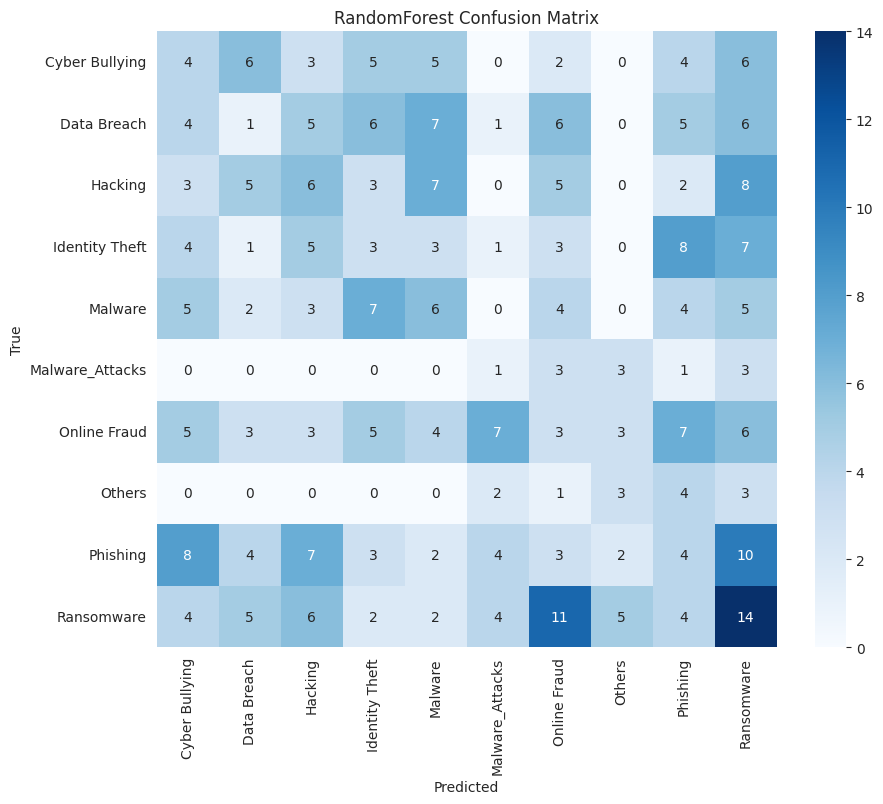

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le_incident.classes_,
    yticklabels=le_incident.classes_,
    cmap='Blues'
)
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
save_fig(plt.gcf(), "plots/rf_confusion_matrix.png")
plt.show()

## Feature Importance

,0
Amount_Lost_INR,0.502298
City_enc,0.188578
Category_enc,0.172888
Year,0.136235


Saved: plots/rf_feature_importance.png


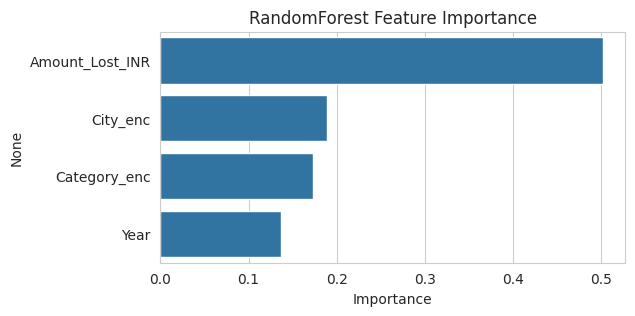

In [20]:
fi = (
    pd.Series(
        rf.feature_importances_,
        index=clf_features
    )
    .sort_values(ascending=False)
)

display(fi)

plt.figure(figsize=(6,3))
sns.barplot(x=fi.values, y=fi.index)
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
save_fig(plt.gcf(), "plots/rf_feature_importance.png")
plt.show()

# TF-Hub USE embeddings for textual visualization

In [21]:
!pip install -q tensorflow-hub

In [22]:
import time
import joblib
import numpy as np
try:
    import tensorflow as tf
    import tensorflow_hub as hub
except Exception as e:
    print("TensorFlow / TF-Hub import error:", e)
    raise
def mk_desc(row):
    parts = []
    if row.get('Incident_Type'): parts.append(str(row.get('Incident_Type')))
    if row.get('City'): parts.append(str(row.get('City')))
    if row.get('Category'): parts.append(str(row.get('Category')))
    amt = row.get('Amount_Lost_INR')
    try:
        if amt is not None and str(amt).strip() != '':
            amt = int(float(amt))
            parts.append(f"loss {amt} INR")
    except Exception:
        pass
    return " | ".join(parts)
df['text_desc'] = df.apply(mk_desc, axis=1).astype(str)
print("Loading Universal Sentence Encoder (may take some time on first run)...")
tfhub_handle = "https://tfhub.dev/google/universal-sentence-encoder/4"
start = time.time()
embed = hub.load(tfhub_handle)
print("Model loaded in %.1fs" % (time.time() - start))
texts = df['text_desc'].tolist()
batch_size = 256
emb_list = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    emb_batch = embed(batch).numpy()
    emb_list.append(emb_batch)

embeddings = np.vstack(emb_list).astype(np.float32)
print("Embeddings shape:", embeddings.shape)

Loading Universal Sentence Encoder (may take some time on first run)...
Model loaded in 27.3s
Embeddings shape: (1200, 512)


## Save embeddings (numpy) and optionally a joblib copy

In [23]:
os.makedirs("results", exist_ok=True)
np.save("results/use_embeddings.npy", embeddings)
joblib.dump(embeddings, "results/use_embeddings.joblib")
print("Saved embeddings → results/use_embeddings.npy  (also joblib copy at results/use_embeddings.joblib)")

Saved embeddings → results/use_embeddings.npy  (also joblib copy at results/use_embeddings.joblib)


## UMAP or t-SNE to reduce embeddings to 2D and plot (static + interactive)

## 'umap'

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
try:
    import umap.umap_ as umap
except Exception as e:
    print("UMAP not available:", e)
    umap = None

from sklearn.manifold import TSNE
if 'embeddings' not in globals():
    try:
        embeddings = np.load("results/use_embeddings.npy")
        print("Loaded embeddings from results/use_embeddings.npy")
    except Exception as e:
        raise RuntimeError("Embeddings not found in memory or disk. Run Cell 10 first.") from e
method = 'umap'

if method == 'umap':
    if umap is None:
        raise RuntimeError("UMAP not installed. Change method to 'tsne' or install umap-learn.")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    emb2d = reducer.fit_transform(embeddings)
else:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca')
    emb2d = tsne.fit_transform(embeddings)
# Attach to dataframe
df['embed_x'] = emb2d[:, 0]
df['embed_y'] = emb2d[:, 1]

# Group rare Incident_Type values into "Other" for clearer coloring
top_n = 12
type_counts = df['Incident_Type'].value_counts()
top_types = set(type_counts.head(top_n).index.tolist())
df['type_group'] = df['Incident_Type'].apply(lambda t: t if t in top_types else 'Other')

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Static matplotlib/seaborn scatter

Saved: plots/use_embed_incident_type.png


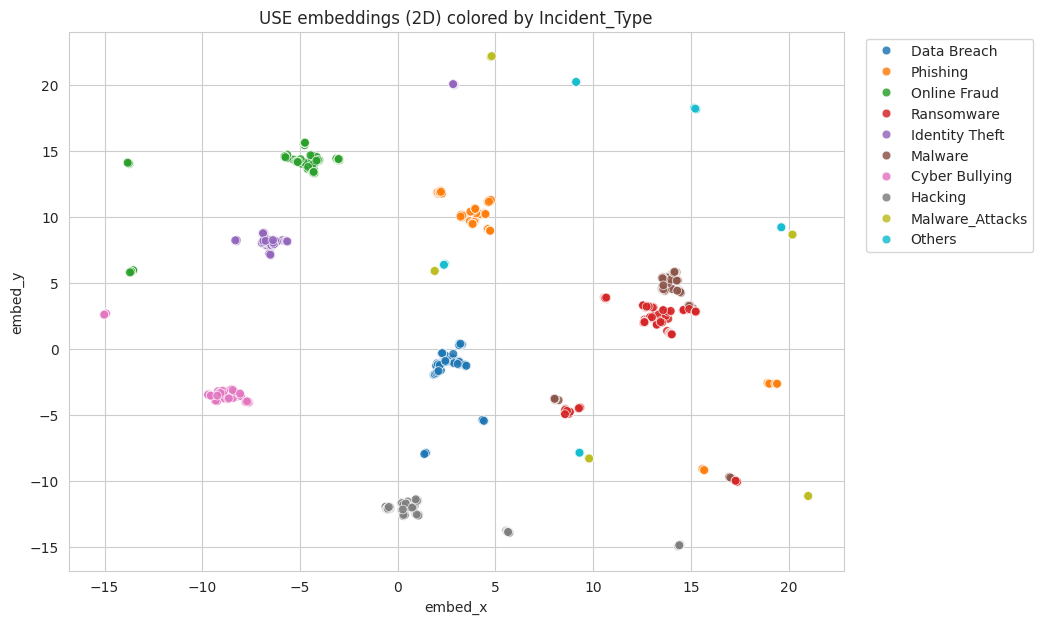

In [25]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='embed_x', y='embed_y', hue='type_group', s=40, alpha=0.85)
plt.title("USE embeddings (2D) colored by Incident_Type")
plt.xlabel("embed_x")
plt.ylabel("embed_y")
plt.legend(loc='best', bbox_to_anchor=(1.02, 1))
save_fig(plt.gcf(), "plots/use_embed_incident_type.png")
plt.show()

## Interactive Plotly scatter (saved to HTML)

In [26]:
fig = px.scatter(
    df,
    x='embed_x',
    y='embed_y',
    color='type_group',
    hover_data=['text_desc', 'City', 'Amount_Lost_INR'],
    title="Interactive USE 2D embeddings"
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
os.makedirs("plots", exist_ok=True)
fig.write_html("plots/use_embed_interactive.html")
print("Interactive USE plot saved to plots/use_embed_interactive.html")
fig.show()


Interactive USE plot saved to plots/use_embed_interactive.html


# Keras Autoencoder on numeric features (2D bottleneck)

## TensorFlow / Keras autoencoder to learn numeric reconstruction errors and a 2D bottleneck for visualization

In [27]:
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
num_cols = ['Amount_Lost_INR']
if 'Year' in df.columns: num_cols.append('Year')
for c in ['City_enc', 'Category_enc']:
    if c in df.columns and c not in num_cols:
        num_cols.append(c)
num_cols = [c for c in num_cols if c in df.columns]

if len(num_cols) == 0:
    raise ValueError("No numeric columns found for autoencoder. Ensure Amount_Lost_INR or encodings exist.")

print("Numeric columns used for autoencoder:", num_cols)
X_num = df[num_cols].fillna(0).astype(float).values
scaler_ae = StandardScaler()
X_scaled = scaler_ae.fit_transform(X_num)
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)
input_dim = X_scaled.shape[1]
encoding_dim = 2

inputs = layers.Input(shape=(input_dim,), name='ae_input')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(16, activation='relu')(x)
encoded = layers.Dense(encoding_dim, activation=None, name='bottleneck')(x)  # linear bottleneck

x = layers.Dense(16, activation='relu')(encoded)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs, outputs, name='autoencoder')
encoder = models.Model(inputs, encoded, name='encoder')

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[es],
    verbose=1
)
bottleneck_2d = encoder.predict(X_scaled)
df['ae_x'] = bottleneck_2d[:, 0]
df['ae_y'] = bottleneck_2d[:, 1]
recon = autoencoder.predict(X_scaled)
mse = np.mean(np.square(recon - X_scaled), axis=1)
df['ae_recon_mse'] = mse

Numeric columns used for autoencoder: ['Amount_Lost_INR', 'Year', 'City_enc', 'Category_enc']


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,790 (10.90 KB)

 Trainable params: 2,790 (10.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.0176 - val_loss: 0.9111
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8979 - val_loss: 0.8102
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8203 - val_loss: 0.7126
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7144 - val_loss: 0.5950
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5951 - val_loss: 0.5244
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5418 - val_loss: 0.4995
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5292 - val_loss: 0.4841
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4813 - val_loss: 0.4742
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4717 - val_loss: 0.4647
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4641 - val_loss: 0.4584
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4460 - val_loss: 0.4526
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

## Save model & scaler & history & bottleneck

Saved autoencoder, encoder, scaler, bottleneck & recon MSE to results/
Saved: plots/ae_bottleneck_2d.png


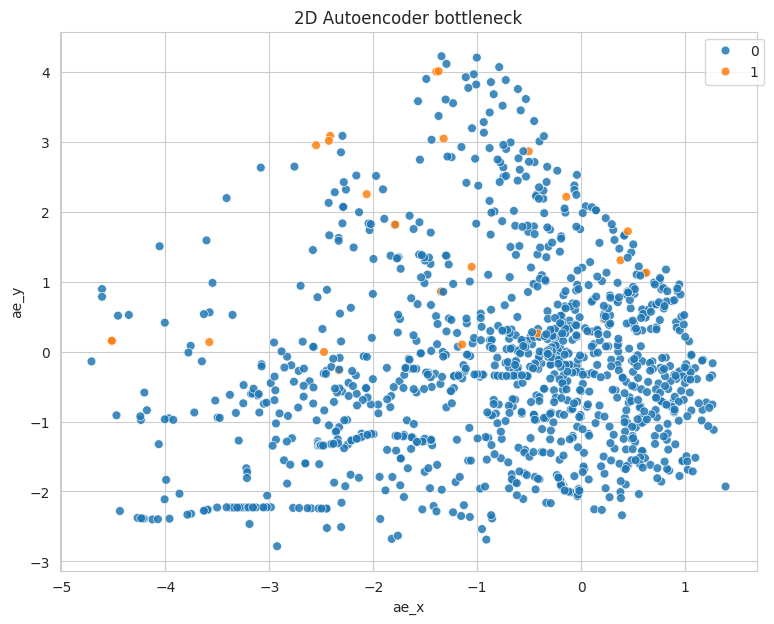

In [29]:
os.makedirs("results", exist_ok=True)
autoencoder.save("results/autoencoder_tf.keras")
encoder.save("results/encoder_tf.keras")
joblib.dump(scaler_ae, "results/scaler_ae.joblib")
np.save("results/ae_bottleneck.npy", bottleneck_2d)
np.save("results/ae_recon_mse.npy", mse)
print("Saved autoencoder, encoder, scaler, bottleneck & recon MSE to results/")
color_col = 'anomaly_synth_loss' if 'anomaly_synth_loss' in df.columns else 'type_group'
plt.figure(figsize=(9,7))
sns.scatterplot(data=df, x='ae_x', y='ae_y', hue=color_col, s=40, alpha=0.85)
plt.title("2D Autoencoder bottleneck")
plt.xlabel("ae_x")
plt.ylabel("ae_y")
plt.legend(loc='best', bbox_to_anchor=(1.02,1))
save_fig(plt.gcf(), "plots/ae_bottleneck_2d.png")
plt.show()

## Latent visualization and reconstruction error

### Compute 2D latent embeddings from encoder

In [30]:
Z = encoder.predict(X_scaled)
df['ae_z1'] = Z[:, 0]
df['ae_z2'] = Z[:, 1]
X_rec = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - X_rec), axis=1)
df['ae_mse'] = mse
threshold = np.percentile(mse, 98)
df['ae_anom'] = (df['ae_mse'] >= threshold).astype(int)
print("Autoencoder MSE threshold (98th percentile):", threshold)
print("Autoencoder anomaly counts (0=normal, 1=anomaly):")
print(df['ae_anom'].value_counts())

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Autoencoder MSE threshold (98th percentile): 0.5759340135816627
Autoencoder anomaly counts (0=normal, 1=anomaly):
ae_anom
0    1176
1      24
Name: count, dtype: int64


## Plot 2D latent space

Saved: plots/ae_latent_scatter.png


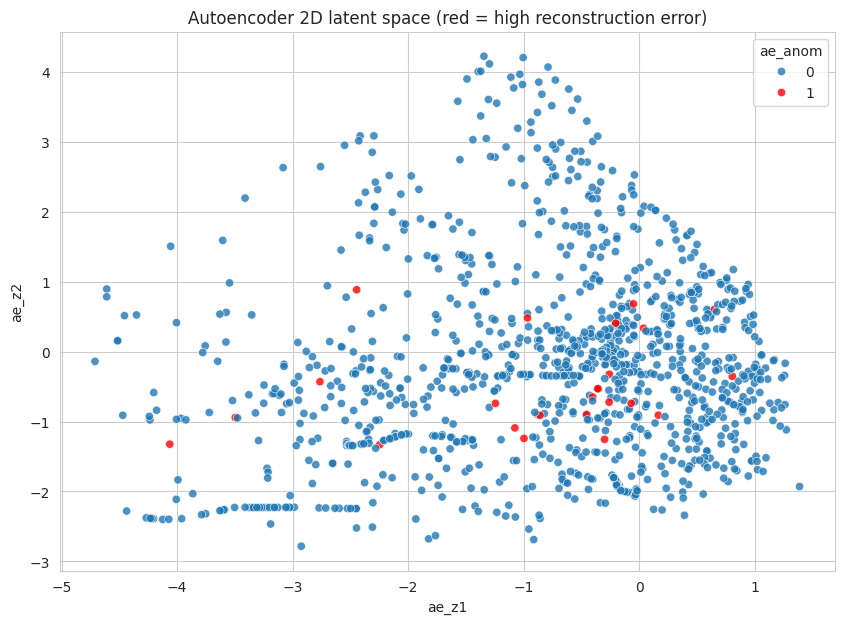

In [31]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df,
    x='ae_z1',
    y='ae_z2',
    hue='ae_anom',
    palette={0: 'C0', 1: 'r'},
    alpha=0.8
)
plt.title("Autoencoder 2D latent space (red = high reconstruction error)")
plt.xlabel("ae_z1")
plt.ylabel("ae_z2")
save_fig(plt.gcf(), "plots/ae_latent_scatter.png")
plt.show()


## Histogram of reconstruction errors

Saved: plots/ae_mse_hist.png


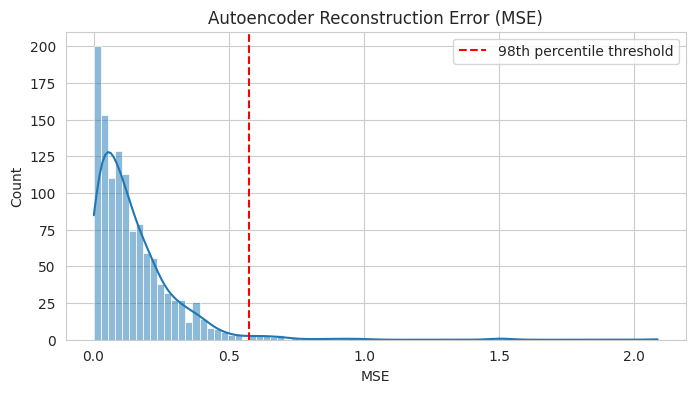

In [32]:
plt.figure(figsize=(8,4))
sns.histplot(df['ae_mse'], bins=80, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='98th percentile threshold')
plt.title("Autoencoder Reconstruction Error (MSE)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
save_fig(plt.gcf(), "plots/ae_mse_hist.png")
plt.show()

## Show top anomalies

In [33]:
display(
    df.sort_values('ae_mse', ascending=False)
    .head(10)[['Incident_Type', 'City', 'Amount_Lost_INR', 'ae_mse']]
)

,Incident_Type,City,Amount_Lost_INR,ae_mse
321,Online Fraud,Ahmedabad,150381,2.085507
925,Phishing,Ahmedabad,320153,1.526340
598,Data Breach,Delhi,233601,1.502450
135,Malware,Bangalore,324694,1.485537
461,Data Breach,Hyderabad,235182,1.009251
830,Ransomware,Chennai,327453,0.963623
577,Ransomware,Ahmedabad,43668,0.929560
506,Identity Theft,Delhi,159059,0.882133
648,Data Breach,Bangalore,95018,0.856647
670,Malware,Ahmedabad,374479,0.786082


## CSVs, models, HTML report

In [43]:
import shutil
import glob
import os

# Ensure results/plots exists
os.makedirs("results/plots", exist_ok=True)

# Copy all PNGs from original plots/ to results/plots/
for file in glob.glob("plots/*.png"):
    shutil.copy(file, "results/plots/")

# Build HTML with paths relative to results/ folder
html = f"""
<html>
<head><meta charset='utf-8'><title>Cybersecurity Cases — Results</title></head>
<body>
<h1>Cybersecurity Cases in India — Results (TensorFlow + ML)</h1>

<h2>Top Incident Types</h2>
<img src='plots/top_incident_types.png' width='800'/>

<h2>USE embedding (static)</h2>
<img src='plots/use_embed_incident_type.png' width='800'/>
<p>Interactive USE visualization: <a href='plots/use_embed_interactive.html' target='_blank'>click here</a></p>

<h2>Autoencoder latent</h2>
<img src='plots/ae_latent_scatter.png' width='800'/>

<h2>IsolationForest anomalies</h2>
<img src='plots/iso_anomalies_scatter.png' width='800'/>

<h2>RandomForest Confusion Matrix</h2>
<img src='plots/rf_confusion_matrix.png' width='800'/>

<h2>RandomForest Feature Importance</h2>
<img src='plots/rf_feature_importance.png' width='600'/>

<h2>Autoencoder Reconstruction Error</h2>
<img src='plots/ae_mse_hist.png' width='800'/>

</body>
</html>
"""

with open("results/report_tf_and_ml_fixed.html", "w", encoding='utf-8') as f:
    f.write(html)

print("Saved fixed HTML report at results/report_tf_and_ml_fixed.html")


Saved fixed HTML report at results/report_tf_and_ml_fixed.html


In [39]:
!pip freeze > requirements.txt
!mv requirements.txt results/requirements.txt

## Zip results and plots for download

In [40]:
import shutil
import os
shutil.make_archive("results_package", 'zip', root_dir=".", base_dir="results")
print("Created results_package.zip containing all results and plots.")
try:
    from google.colab import files
    files.download("results_package_CybersecurityIncidentAnalysis.zip")
except Exception:
    print("Download not triggered (likely running locally). You can manually download results_package.zip")

Created results_package.zip containing all results and plots.
Download not triggered (likely running locally). You can manually download results_package.zip


# Conclusion

## What we did
- Loaded and preprocessed the dataset.
- Performed exploratory analysis identifying top incident types, cities, and monetary losses.
- Implemented **unsupervised anomaly detection** using IsolationForest and a TensorFlow Keras autoencoder. Both produced anomaly candidates and visualizations.
- Implemented a **supervised RandomForest baseline** for predicting `Incident_Type` using metadata features.
- Used **TensorFlow Hub (Universal Sentence Encoder)** to embed synthesized text descriptions and visualized those embeddings with UMAP/t-SNE.
- Saved all outputs (**plots, CSVs, models**) to `plots/` and `results/` for inclusion in the thesis appendix.

## How to include in dissertation
- Include plots from `plots/` in the **Implementation & Results** chapter.
- Include the `results/*.csv` tables as evidence in the **Analysis** chapter.
- Report the **modeling approach**, hyperparameters (e.g., IsolationForest contamination, autoencoder architecture, RF n_estimators), and limitations (synthetic labels, limited features, proxy textual descriptions).
- Reference **TF-Hub USE** when discussing embedding methodology.